# Tutorial 1 - Finding, Saving, and Loading Elevation Data for Your Study Area

This notebook demonstrates a simple workflow for obtaining elevation data (DEM) for a study area using a shapefile and the National Map 10m (1/3 arcsecond) DEM accessed through their API.

In [ ]:
# Dealing with LFS for binder-friendly data science
from pathlib import Path
import requests
import geopandas as gpd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# Folders we’ll use (Binder-friendly, and safe even if gitignored)
DATA = Path("data")
DATA_LARGE = DATA / "large"
DATA_DERIVED = DATA / "derived"
DATA_LARGE.mkdir(parents=True, exist_ok=True)
DATA_DERIVED.mkdir(parents=True, exist_ok=True)


In [2]:
import sys

def fetch(url: str, dest: Path, chunk=1<<20):
    """Download url to dest if missing. Chunked with a simple progress bar."""
    if dest.exists() and dest.stat().st_size > 0:
        print(f"✓ Using cached file: {dest} ({dest.stat().st_size/1e6:.1f} MB)")
        return dest
    with requests.get(url, stream=True, timeout=180) as r:
        r.raise_for_status()
        total = int(r.headers.get("Content-Length", 0))
        print(f"↓ {url}\n→ {dest} ({total/1e6:.1f} MB)" if total else f"↓ {url}\n→ {dest}")
        done = 0
        with open(dest, "wb") as f:
            for part in r.iter_content(chunk_size=chunk):
                if not part: continue
                f.write(part); done += len(part)
                if total:
                    pct = 100 * done / total
                    sys.stdout.write(f"\r  {pct:5.1f}% ({done/1e6:.1f}/{total/1e6:.1f} MB)")
                    sys.stdout.flush()
    print("\n✓ Done.")
    return dest

## 1. Load Study Area Shapefile

We'll use `geopandas` to load the study area shapefile located at `data/Study_Area`.

geopandas is a Python library used for working with geospatial data. It extends the capabilities of pandas to allow spatial operations on geometric types.

     Shape_Leng    Shape_Area  \
0  34363.321288  7.303913e+07   

                                            geometry  
0  POLYGON Z ((-12428367.605 4190219.988 0, -1241...  


<Axes: >

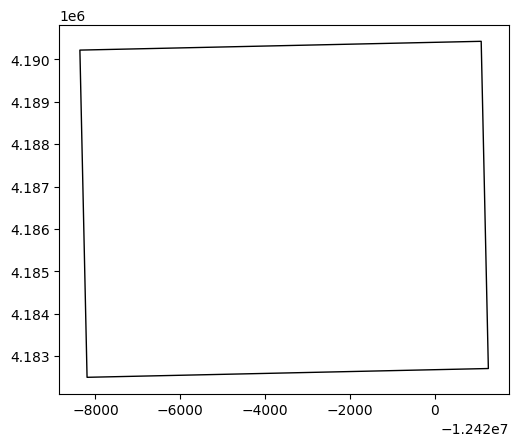

In [3]:
import geopandas as gpd

# Load the study area shapefile
shapefile_path = Path("data/Study_Area.shp")
gdf = gpd.read_file(shapefile_path)

# Display basic info
print(gdf)
gdf.plot(edgecolor='k', facecolor='none')

## 2. Find Elevation Data for Your Area

We'll use the National Map's Elevation Point Query Service to find a 30m DEM tile that covers our study area. For simplicity, we'll use the bounding box of the shapefile.

In [4]:

# Ensure your study area is WGS84 lon/lat
gdf4326 = gdf.to_crs(4326)           # <-- important
minx, miny, maxx, maxy = gdf4326.total_bounds

params = {
    "bbox": f"{minx},{miny},{maxx},{maxy}",
    "q": "1 arc-second DEM",         # also try: "Digital Elevation Model (DEM) 1 arc-second"
    "prodFormats": "GeoTIFF",        # filter to GeoTIFFs
    "max": 50                        # number of items to return
}

url = "https://tnmaccess.nationalmap.gov/api/v1/products"
r = requests.get(url, params=params, timeout=60)
r.raise_for_status()
data = r.json()

# Collect GeoTIFF URLs (handles both 'downloadURL' and 'files' patterns)
tif_urls = []
for item in data.get("items", []):
    u = item.get("downloadURL", "")
    if u.endswith(".tif"):
        tif_urls.append(u)
    for f in item.get("files", []):
        fu = f.get("url", "")
        if fu.endswith(".tif"):
            tif_urls.append(fu)

print("Found DEMs:", len(tif_urls))
#print("Example:", tif_urls if tif_urls else None)

for i, url in enumerate(tif_urls):
    print(f"{i}: {url}")

Found DEMs: 8
0: https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/historical/n36w112/USGS_1_n36w112_20210106.tif
1: https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/historical/n36w112/USGS_1_n36w112_20230418.tif
2: https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/historical/n36w112/USGS_1_n36w112_20240614.tif
3: https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/historical/n36w112/USGS_1_n36w112_20190924.tif
4: https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/TIFF/historical/n36w112/USGS_13_n36w112_20210106.tif
5: https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/TIFF/historical/n36w112/USGS_13_n36w112_20230418.tif
6: https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/TIFF/historical/n36w112/USGS_13_n36w112_20240614.tif
7: https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/TIFF/historical/n36w112/USGS_13_n36w112_20190924.tif


## 3. Download Elevation Data

Download the DEM GeoTIFF file for the study area.

In [5]:
from urllib.parse import urlparse

# Option A: pick first 1/3 arcsecond result -- 4th item in list
dem_url = tif_urls[4] if tif_urls else None

# Option B (fixed tile — comment Option A and uncomment this to force a known URL)
# dem_url = "https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/TIFF/historical/n36w112/USGS_13_n36w112_20210106.tif"

if not dem_url:
    raise RuntimeError("No DEM URL found. Check TNM query.")

# Use the URL’s file name to save locally
dem_name = Path(urlparse(dem_url).path).name or "study_area_dem.tif"
dem_path = DATA_LARGE / dem_name

dem_path = fetch(dem_url, dem_path)
print("DEM local path:", dem_path)

↓ https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/TIFF/historical/n36w112/USGS_13_n36w112_20210106.tif
→ data\large\USGS_13_n36w112_20210106.tif (365.3 MB)
  100.0% (365.3/365.3 MB)
✓ Done.
DEM local path: data\large\USGS_13_n36w112_20210106.tif


## 4. Save the DEM or TIFF

The DEM file has been saved as a GeoTIFF in the `data/large` folder. Note that all processing in binder is temporary, if you want to save or download uncomment the lines in the last cell and download the output as a zip file.

## 5. Load and Display Elevation Data

We'll use `rasterio` and `matplotlib` to load and visualize the elevation data.

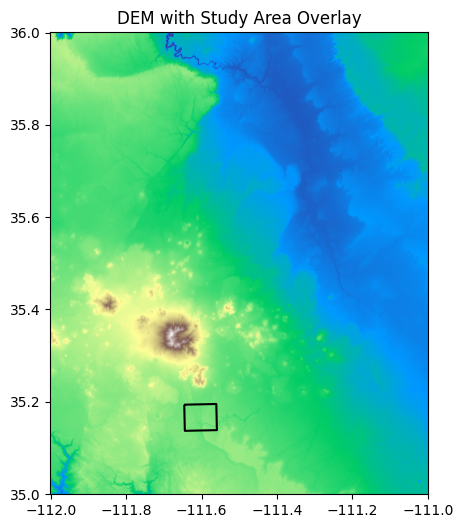

In [8]:
import matplotlib.pyplot as plt 
from rasterio.plot import show
# Open DEM and reproject study area to match DEM CRS
with rasterio.open(dem_path) as src:
    dem_crs = src.crs

gdf_dem = gdf.to_crs(dem_crs)  # IMPORTANT: match CRS for correct overlay

# Plot DEM, then overlay boundaries
with rasterio.open(dem_path) as src:
    fig, ax = plt.subplots(figsize=(8, 6))
    show(src, ax=ax, cmap="terrain")
    gdf_dem.boundary.plot(ax=ax, color="k", linewidth=1.5)
    ax.set_title("DEM with Study Area Overlay")
    plt.show()

# 6) Clip the DEM to the shapefile (mask by polygon) and save

In [9]:
from shapely.geometry import mapping
import numpy as np
from rasterio.mask import mask
from shapely.geometry import mapping
import os

# Union multi-part polygons to one geometry (faster, cleaner mask)
study_geom = [mapping(gdf_dem.union_all())]

with rasterio.open(dem_path) as src:
    out_image, out_transform = mask(src, study_geom, crop=True, nodata=src.nodata)
    out_meta = src.meta.copy()

# Update metadata for the clipped raster
out_meta.update({
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

clipped_dir = "data/derived"
os.makedirs(clipped_dir, exist_ok=True)
dem_clipped_path = os.path.join(clipped_dir, "study_area_dem_clipped.tif")

# Preserve nodata; if original had none, set one
if out_meta.get("nodata") is None:
    out_meta["nodata"] = -9999
    # Replace NaNs with nodata if needed
    out_image = np.where(np.isnan(out_image), out_meta["nodata"], out_image)

with rasterio.open(dem_clipped_path, "w", **out_meta) as dst:
    dst.write(out_image)

print(f"Clipped DEM saved to: {dem_clipped_path}")

Clipped DEM saved to: data/derived\study_area_dem_clipped.tif


# 7) Plot the clipped DEM with shapefile overlay

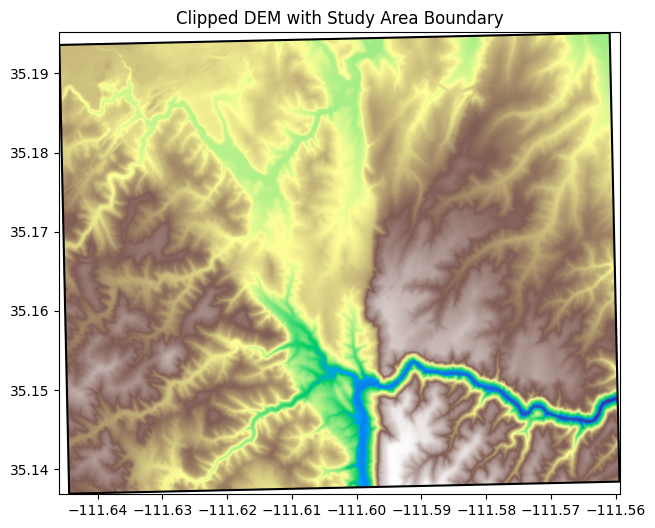

In [10]:
with rasterio.open(dem_clipped_path) as src:
    fig, ax = plt.subplots(figsize=(8, 6))
    show(src, ax=ax, cmap="terrain")
    gdf_dem.boundary.plot(ax=ax, color="k", linewidth=1.5)
    ax.set_title("Clipped DEM with Study Area Boundary")
    plt.show()

In [11]:
import shutil
from IPython.display import FileLink

zip_path = Path("derived_outputs.zip")
if zip_path.exists():
    zip_path.unlink()
shutil.make_archive(zip_path.stem, "zip", DATA_DERIVED)
FileLink(str(zip_path))

c:\Users\rl587\PROJECTS\dem-site-assessment\derived_outputs.zip